# Tabla de contenidos
Ejecutar en orden las siguientes secciones:
1. [Configuración e imports](#sec1)
2. [Tools](#sec2)
3. [State](#sec3)
4. [Router](#sec4)
5. [Agente](#sec5)
6. [Evaluación](#sec6)

# Configuración e imports <a name="sec1"></a>

In [1]:
from dotenv import load_dotenv
load_dotenv("api_keys.env")

import os
from typing import Literal
from datetime import datetime

%load_ext autoreload
%autoreload 2

from pydantic import BaseModel, Field
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model
from langgraph.graph import (
    MessagesState,
    StateGraph,
    START,
    END,
)
from langgraph.types import Command

# Módulos del paquete email_assistant
from email_assistant.utils import (
    parse_email,
    format_email_markdown,
    show_graph,
)
from email_assistant.prompts import (
    triage_system_prompt,
    triage_user_prompt,
    default_triage_instructions,
    default_background,
    agent_system_prompt,
    default_response_preferences,
    default_cal_preferences,
)
from email_assistant.tools.default.prompt_templates import AGENT_TOOLS_PROMPT

print("OPENAI:", bool(os.getenv("OPENAI_API_KEY")))
print("LANGSMITH:", bool(os.getenv("LANGSMITH_API_KEY")))


OPENAI: True
LANGSMITH: True


# Tools <a name="sec2"></a>

In [2]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}' and content: {content}"

@tool
def schedule_meeting(
    attendees: list[str], subject: str, duration_minutes: int, preferred_day: datetime, start_time: int
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return (
        f"Meeting '{subject}' scheduled on {date_str} at {start_time} "
        f"for {duration_minutes} minutes with {len(attendees)} attendees"
    )

@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

# 🔹 NEW TOOLS

@tool
def search_emails(query: str, date_from: str | None = None) -> str:
    """Search past emails by content, sender, or date."""
    # Placeholder - here you would call your real email search
    if date_from:
        return (
            f"[SIMULATION] Found several emails related to '{query}' "
            f"from {date_from} onwards."
        )
    return f"[SIMULATION] Found several emails related to '{query}'."

@tool
def summarize_email_thread(thread_id: str) -> str:
    """Summarize a long email thread."""
    # Placeholder - in a real app you would fetch the thread and summarize it
    return (
        f"[SIMULATION] Summary for thread {thread_id}: "
        "The customer is requesting changes to feature X and expects a reply this week."
    )

@tool
def check_slack_mentions() -> str:
    """Check unread or pending Slack mentions."""
    # Placeholder - here you would call the Slack API
    return "[SIMULATION] You have 3 unread mentions in Slack channel #general."

@tool
def create_calendar_event_from_email(email_content: str) -> str:
    """Extract meeting info from an email and create a calendar event."""
    # Placeholder - here you would parse the email and create a real event
    return (
        "[SIMULATION] Created calendar event: 'Meeting with client' "
        "on Friday at 3pm based on the email content."
    )

@tool
class Done(BaseModel):
    """Use this tool when the email has been fully handled and no further action is required."""
    done: bool


# State <a name="sec3"></a>

In [3]:
class State(MessagesState):
    # Entrada del correo electrónico
    email_input: dict

    # Decisión del traige
    classification_decision: Literal["ignore", "respond", "notify"]

# Router <a name="sec4"></a>

In [4]:
class RouterSchema(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

# Initialize the LLM for use with router / structured output
llm = init_chat_model("openai:gpt-4.1", temperature=0.0)
llm_router = llm.with_structured_output(RouterSchema)

def triage_router(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """Analyze email content to decide if we should respond, notify, or ignore."""

    author, to, subject, email_thread = parse_email(state["email_input"])
    system_prompt = triage_system_prompt.format(
        background=default_background,
        triage_instructions=default_triage_instructions
    )

    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )

    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email: \n\n{format_email_markdown(subject, author, to, email_thread)}",
                }
            ],
            "classification_decision": result.classification,
        }

    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        goto = END
        update =  {
            "classification_decision": result.classification,
        }

    elif result.classification == "notify":
        print("🔔 Classification: NOTIFY - This email contains important information")
        # For now, we go to END. But we will add to this later!
        goto = END
        update = {
            "classification_decision": result.classification,
        }

    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

# Agente <a name="sec5"></a>

In [5]:
CUSTOM_AGENT_TOOLS_PROMPT = AGENT_TOOLS_PROMPT + """

Additional tools you can use:

- search_emails(query, date_from=None): Search past emails by content, sender, or date.
- summarize_email_thread(thread_id): Summarize a long email thread given its thread ID.
- check_slack_mentions(): Check for pending Slack mentions that might require action.
- create_calendar_event_from_email(email_content): Extract meeting details from an email and create a calendar event.
"""

# Collect all tools
tools = [ write_email, schedule_meeting, check_calendar_availability, search_emails, summarize_email_thread, check_slack_mentions,
          create_calendar_event_from_email,
          Done, ]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize the LLM, enforcing tool use
llm = init_chat_model("openai:gpt-4.1", temperature=0.0)
llm_with_tools = llm.bind_tools(tools, tool_choice="any")

def llm_call(state: State):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            # Invoke the LLM
            llm_with_tools.invoke(
                # Add the system prompt
                [
                    {"role": "system", "content": agent_system_prompt.format(
                        tools_prompt=CUSTOM_AGENT_TOOLS_PROMPT,
                        background=default_background,
                        response_preferences=default_response_preferences,
                        cal_preferences=default_cal_preferences,
                    )}
                ]
                # Add the current messages to the prompt
                + state["messages"]
            )
        ]
    }

def tool_handler(state: State):
    """Performs the tool call."""

    # List for tool messages
    result = []

    # Iterate through tool calls
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool
        tool = tools_by_name[tool_call["name"]]
        # Run it
        observation = tool.invoke(tool_call["args"])
        # Create a tool message
        result.append({"role": "tool", "content" : observation, "tool_call_id": tool_call["id"]})

    # Add it to our messages
    return {"messages": result}

def should_continue(state: State) -> Literal["tool_handler", "__end__"]:
    """Route to tool handler, or end if Done tool called."""

    # Get the last message
    messages = state["messages"]
    last_message = messages[-1]

    # Check if it's a Done tool call
    if last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            if tool_call["name"] == "Done":
                return END
            else:
                return "tool_handler"

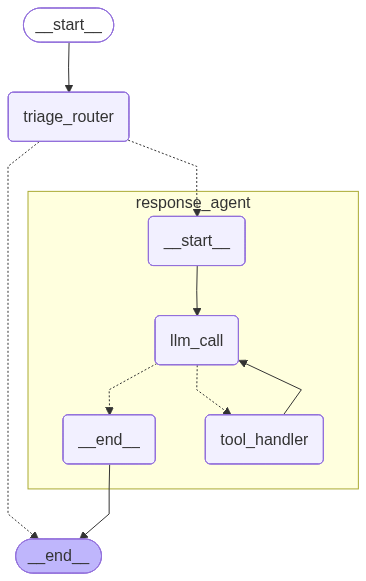

In [6]:
# Build workflow
overall_workflow = StateGraph(State)

# Add nodes
overall_workflow.add_node("llm_call", llm_call)
overall_workflow.add_node("tool_handler", tool_handler)

# Add edges
overall_workflow.add_edge(START, "llm_call")
overall_workflow.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_handler": "tool_handler",
        END: END,
    },
)
overall_workflow.add_edge("tool_handler", "llm_call")

# Compile the agent
agent = overall_workflow.compile()

overall_workflow = (
    StateGraph(State)
    .add_node(triage_router)
    .add_node("response_agent", agent)
    .add_edge(START, "triage_router")
).compile()

show_graph(overall_workflow, xray=True)

# Pruebas

In [7]:
# ----- Ejemplo 1 -----
email_input = {
    "author": "System Admin <sysadmin@company.com>",
    "to": "Development Team <dev@company.com>",
    "subject": "Scheduled maintenance - database downtime",
    "email_thread": (
        "Hi team,\n\n"
        "This is a reminder that we'll be performing scheduled maintenance..."
    ),
}

result = overall_workflow.invoke({"email_input": email_input})
for m in result["messages"]:
    m.pretty_print()

# ----- Ejemplo 2 -----
email_input = {
    "author": "Client Product Manager <pm@bigclient.com>",
    "to": "Support Team <support@company.com>",
    "subject": "Follow-up on last quarter results and roadmap",
    "email_thread": (
        "Hi team,\n\n"
        "We have been discussing internally the results from last quarter and the impact "
        "of the latest release. Could you please:\n"
        "1) Search for previous emails where we discussed the Q4 results, and\n"
        "2) Summarize the main decisions and action items from those threads?\n\n"
        "It would be great to have a clear summary before our meeting next week.\n\n"
        "Best,\n"
        "Client PM"
    ),
}

result = overall_workflow.invoke({"email_input": email_input})
for m in result["messages"]:
    m.pretty_print()

🔔 Classification: NOTIFY - This email contains important information
📧 Classification: RESPOND - This email requires a response
================================ Human Message =================================

Respond to the email: 



**Subject**: Follow-up on last quarter results and roadmap
**From**: Client Product Manager <pm@bigclient.com>
**To**: Support Team <support@company.com>

Hi team,

We have been discussing internally the results from last quarter and the impact of the latest release. Could you please:
1) Search for previous emails where we discussed the Q4 results, and
2) Summarize the main decisions and action items from those threads?

It would be great to have a clear summary before our meeting next week.

Best,
Client PM

---

================================== Ai Message ==================================
Tool Calls:
  search_emails (call_N3YbQiiegLCo98fBIiyGfCp6)
 Call ID: call_N3YbQiiegLCo98fBIiyGfCp6
  Args:
    query: Q4 results
=================================

# Evaluación

In [8]:
from langsmith import Client

# Agente multiagente
from email_assistant.email_assistant import email_assistant

# Dataset de evaluación
from email_assistant.eval.email_dataset import (
    examples_triage,         # lista de ejemplos para triage
    # email_inputs,          # descomentar si luego quieres usarlo
    # response_criteria_list # descomentar si luego construyes dataset de criterios
)

# Utilidades para convertir mensajes a texto largo
from email_assistant.utils import format_messages_string

# Prompt para LLM-as-judge
from email_assistant.eval.prompts import RESPONSE_CRITERIA_SYSTEM_PROMPT


In [9]:
client = Client()
DATASET_NAME_TRIAGE = "E-mail 50-Triage Evaluation"

def create_or_load_triage_dataset(
    client: Client,
    dataset_name: str = DATASET_NAME_TRIAGE,
):
    """
    Crea el dataset de triage en LangSmith si no existe.
    Usa examples_triage definidos en email_assistant.eval.email_dataset.
    """
    if not client.has_dataset(dataset_name=dataset_name):
        dataset = client.create_dataset(
            dataset_name=dataset_name,
            description="Dataset de e-mails y sus decisiones de triage."
        )
        client.create_examples(dataset_id=dataset.id, examples=examples_triage)
    # Si ya existe, simplemente no hace nada
    return dataset_name


# Ejecutar una sola vez al arrancar el notebook
create_or_load_triage_dataset(client, DATASET_NAME_TRIAGE)

'E-mail 50-Triage Evaluation'

In [10]:
def target_email_assistant(inputs: dict) -> dict:
    """
    Procesa un email a través del nodo de triage del workflow email_assistant.

    Espera que inputs tenga la forma:
        {"email_input": {...}}

    Devuelve:
        {"classification_decision": "<ignore|respond|notify>"}
    """
    # Ejecutar solo el router de triage
    result_state = email_assistant.nodes["triage_router"].invoke(
        {"email_input": inputs["email_input"]}
    )
    # La decisión se guarda en el estado del nodo
    classification = result_state.update["classification_decision"]
    return {"classification_decision": classification}

In [11]:
def classification_evaluator(outputs: dict, reference_outputs: dict) -> bool:
    """
    Evalúa si la clasificación devuelta por el agente coincide con la de referencia.
    outputs: {"classification_decision": "..."}
    reference_outputs: {"classification": "..."}

    Retorna True si coincide (ignorando mayúsculas/minúsculas).
    """
    agent_label = str(outputs.get("classification_decision", "")).strip().casefold()
    ref_label = str(reference_outputs.get("classification", "")).strip().casefold()
    return agent_label == ref_label

In [12]:
RUN_TRIAGE_EXPERIMENT = True  # pon True cuando quieras lanzar la evaluación

if RUN_TRIAGE_EXPERIMENT:
    triage_experiment = client.evaluate(
        # Modelo/función a evaluar
        target_email_assistant,
        # Nombre del dataset en LangSmith
        data=DATASET_NAME_TRIAGE,
        # Evaluadores a aplicar
        evaluators=[classification_evaluator],
        # Prefijo del nombre de experimento
        experiment_prefix="Email Assistant - 50 Triage",
        # Paralelismo
        max_concurrency=2,
    )

c:\Users\ANDRES\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'Email Assistant - 50 Triage-6927156e' at:
https://smith.langchain.com/o/aaa6621b-4c04-49a0-aa74-26c37fbb2e0f/datasets/3f658b78-122c-4882-a8f0-d01bd69dc425/compare?selectedSessions=c820002b-ac86-4033-b514-50407054c6da




1it [00:01,  1.92s/it]

📧 Classification: RESPOND - This email requires a response
📧 Classification: RESPOND - This email requires a response


2it [00:03,  1.57s/it]

📧 Classification: RESPOND - This email requires a response


3it [00:03,  1.03it/s]

📧 Classification: RESPOND - This email requires a response


4it [00:04,  1.00s/it]

📧 Classification: RESPOND - This email requires a response


6it [00:05,  1.21it/s]

🚫 Classification: IGNORE - This email can be safely ignored
🔔 Classification: NOTIFY - This email contains important information


7it [00:07,  1.07s/it]

📧 Classification: RESPOND - This email requires a response


8it [00:08,  1.05it/s]

🔔 Classification: NOTIFY - This email contains important information


10it [00:09,  1.40it/s]

🔔 Classification: NOTIFY - This email contains important information
📧 Classification: RESPOND - This email requires a response


11it [00:11,  1.02s/it]

📧 Classification: RESPOND - This email requires a response


12it [00:11,  1.10it/s]

🚫 Classification: IGNORE - This email can be safely ignored


13it [00:13,  1.02s/it]

🔔 Classification: NOTIFY - This email contains important information


14it [00:13,  1.20it/s]

📧 Classification: RESPOND - This email requires a response


16it [00:15,  1.16it/s]

📧 Classification: RESPOND - This email requires a response


17it [00:16,  1.05s/it]

📧 Classification: RESPOND - This email requires a response
📧 Classification: RESPOND - This email requires a response


18it [00:18,  1.25s/it]

📧 Classification: RESPOND - This email requires a response
📧 Classification: RESPOND - This email requires a response


20it [00:20,  1.11s/it]

📧 Classification: RESPOND - This email requires a response


21it [00:20,  1.04it/s]

🔔 Classification: NOTIFY - This email contains important information
🔔 Classification: NOTIFY - This email contains important information


23it [00:23,  1.05s/it]

📧 Classification: RESPOND - This email requires a response


24it [00:24,  1.01it/s]

📧 Classification: RESPOND - This email requires a response


25it [00:24,  1.17it/s]

🚫 Classification: IGNORE - This email can be safely ignored


27it [00:25,  1.45it/s]

📧 Classification: RESPOND - This email requires a response
📧 Classification: RESPOND - This email requires a response


28it [00:26,  1.29it/s]

📧 Classification: RESPOND - This email requires a response


30it [00:27,  1.38it/s]

🔔 Classification: NOTIFY - This email contains important information📧 Classification: RESPOND - This email requires a response

📧 Classification: RESPOND - This email requires a response


32it [00:30,  1.15it/s]

📧 Classification: RESPOND - This email requires a response


33it [00:32,  1.23s/it]

📧 Classification: RESPOND - This email requires a response


34it [00:33,  1.10s/it]

📧 Classification: RESPOND - This email requires a response


35it [00:34,  1.09s/it]

📧 Classification: RESPOND - This email requires a response


36it [00:35,  1.07s/it]

📧 Classification: RESPOND - This email requires a response


38it [00:36,  1.20it/s]

📧 Classification: RESPOND - This email requires a response
🔔 Classification: NOTIFY - This email contains important information


39it [00:38,  1.10s/it]

📧 Classification: RESPOND - This email requires a response


40it [00:38,  1.11it/s]

🚫 Classification: IGNORE - This email can be safely ignored


43it [00:40,  1.66it/s]

📧 Classification: RESPOND - This email requires a response
📧 Classification: RESPOND - This email requires a response


44it [00:41,  1.26it/s]

🔔 Classification: NOTIFY - This email contains important information
📧 Classification: RESPOND - This email requires a response


46it [00:43,  1.27it/s]

🔔 Classification: NOTIFY - This email contains important information
🚫 Classification: IGNORE - This email can be safely ignored


47it [00:44,  1.04it/s]

📧 Classification: RESPOND - This email requires a response


48it [00:44,  1.28it/s]

📧 Classification: RESPOND - This email requires a response


49it [00:46,  1.09s/it]

🚫 Classification: IGNORE - This email can be safely ignored


50it [00:47,  1.05it/s]


In [13]:
!python tests/run_all_tests.py

Exception in thread Thread-1 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\ANDRES\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "c:\Users\ANDRES\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\ANDRES\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1552, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "c:\Users\ANDRES\AppData\Local\Programs\Python\Python311\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 682: character maps to <undefined>



Running tests for email_assistant...
   Project: E-mail Tool Calling and Response Evaluation 50 Samples

ℹ️ Test results for email_assistant are being logged to LangSmith

Running test_response.py for email_assistant...
   Experiment: Test: test_response.py | Agent: email_assistant
None
